# Testing different pipeline elements
This notebook contains different miscellaneous tests to ensure that the behavior of our pipeline elements is correct.

In [6]:
import json
from torch.utils.data import DataLoader
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import time
import matplotlib.pyplot as plt
from matplotlib import cm as CM
import cv2
import torchvision.transforms as transforms
from tifffile import tifffile as tif

import sys
sys.path.append('/Users/emiliolr/Desktop/counting-cranes')
sys.path.append(os.path.join(str(Path(os.getcwd()).parent), 'density_estimation', 'ASPDNet'))
sys.path.append(os.path.join(str(Path(os.getcwd()).parent), 'object_detection'))

from bird_dataset import *
from utils import *
from density_estimation.generate_density import *
from full_pipeline import *

In [7]:
config = json.load(open('/Users/emiliolr/Desktop/counting-cranes/config.json', 'r'))
DATA_FP = config['data_filepath_local']
CODE_FP = config['code_filepath_local']
SEED = config['random_seed']

## Testing utility functions (`utils.py`)

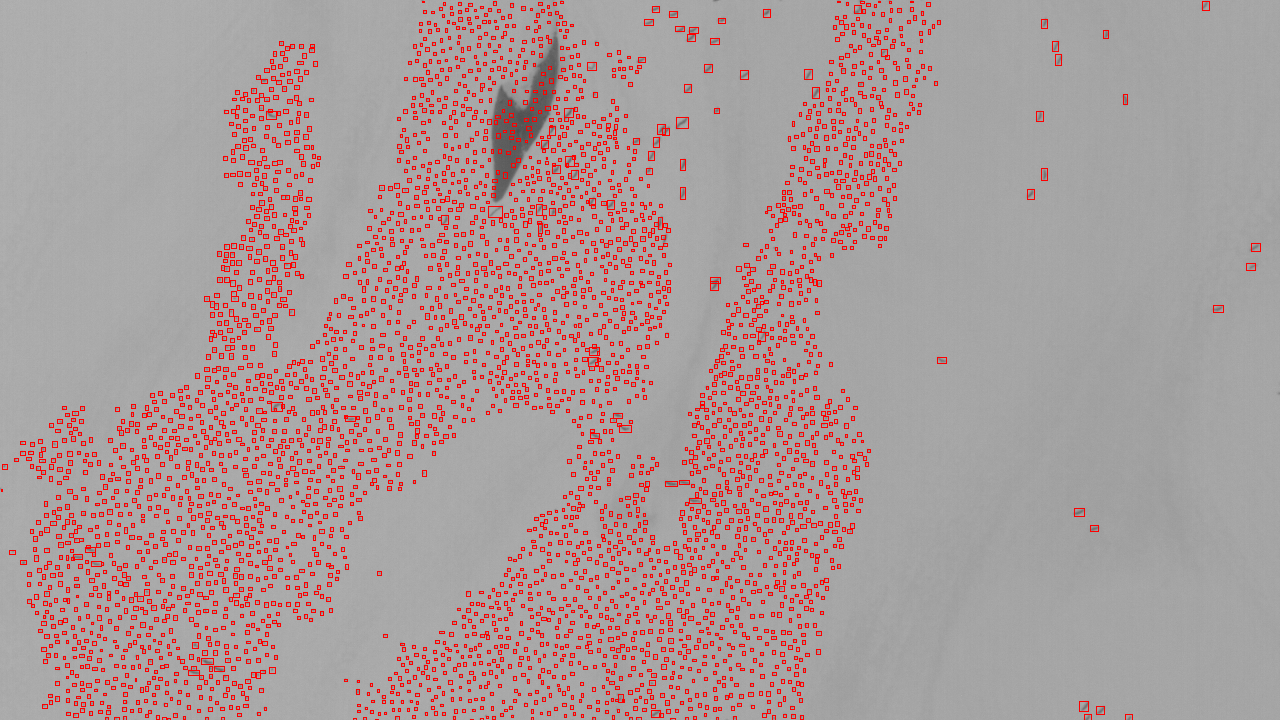

In [5]:
#Checking that bbox extraction and visualization work correctly
img_fp = os.path.join(DATA_FP, 'images/FLIR2_20210321_201851_358_2510.TIF')
annot_fp = os.path.join(DATA_FP, 'annotations/FLIR2_20210321_201851_358_2510.xml')

visualize_bboxes(img_fp, annot_fp)

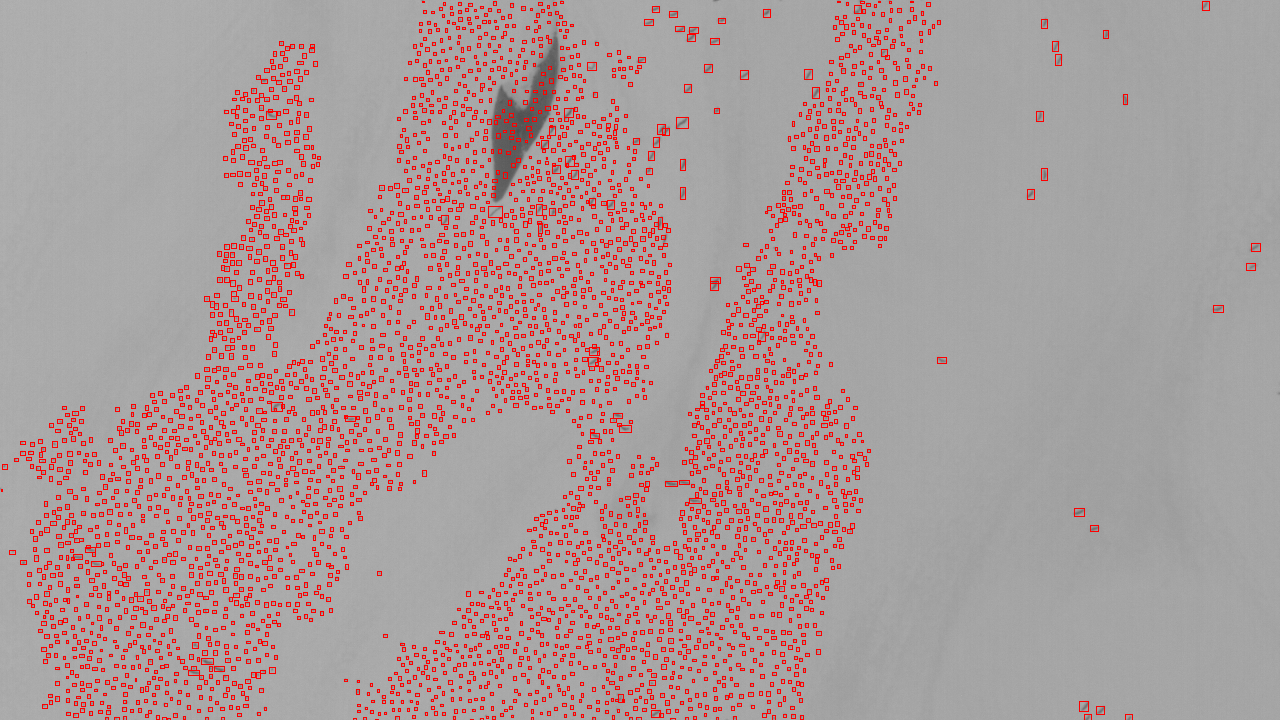

In [4]:
#Checking secondary behavior for visualize_bboxes
pil_img = Image.open(img_fp)
bboxes = get_bboxes(annot_fp)

visualize_bboxes(None, None, pil_img, bboxes)

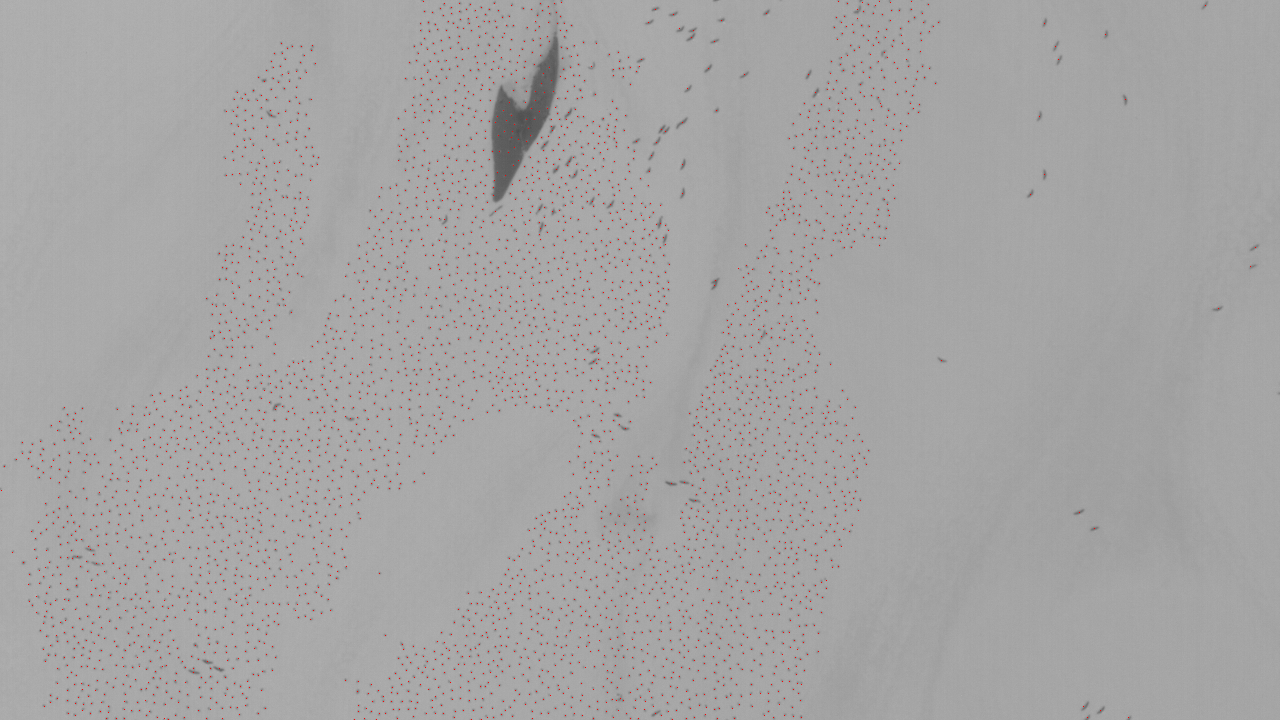

In [4]:
#Checking that point annotation translation and visualization work correctly
visualize_points(img_fp, annot_fp)

In [6]:
#Testing regression annotation type
print(f'{img_fp.split("/")[-1]} contains {get_regression(annot_fp)} birds in total')

FLIR2_20210321_201851_358_2510.TIF contains 4292 birds in total


## Testing the `BirdDataset` object (bboxes)


In [3]:
#Putting the dataset in a DataLoader
bird_dataset = BirdDataset(root_dir = DATA_FP, 
                           transforms = get_transforms(train = False), 
                           annotation_mode = 'bboxes',
                           tiling_method = 'random')
dataloader = DataLoader(bird_dataset, 
                        batch_size = 1, 
                        shuffle = True, 
                        collate_fn = collate_tiles_object_detection)

#Pulling a batch out of the iterator
images, targets, _, _ = next(iter(dataloader))
print(f'Batch size of {len(images)} with each tensor of shape {images[0].shape}')
print(f'We have a {type(targets)} of {type(targets[0])}')

Batch size of 18 with each tensor of shape torch.Size([3, 224, 224])
We have a <class 'list'> of <class 'dict'>


In [4]:
#Checking data types of dictionary elements
t = targets[0]
print(f'Bounding boxes are {t["boxes"].dtype}')
print(f'Labels are {t["labels"].dtype}')

Bounding boxes are torch.float32
Labels are torch.int64


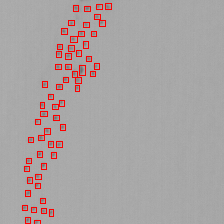

In [5]:
#Inspecting images
index = 2
img = np.moveaxis(images[index].numpy(), 0, -1) * 255
bb = targets[index]['boxes'].tolist()

pil_img = Image.fromarray(img.astype(np.uint8))
draw = ImageDraw.Draw(pil_img)
for b in bb:
    draw.rectangle(b, outline = 'red', width = 1)
pil_img

In [6]:
#Checking the target dictionaries
print(f'{len(targets[index]["boxes"])} birds in tile {index}')

59 birds in tile 2


In [11]:
#Number of negative examples in the batch?
neg_ex_ct = 0
for t in targets:
    if len(t['boxes']) == 0:
        neg_ex_ct += 1
print(f'We have {neg_ex_ct} negative examples in this batch')

We have 0 negative examples in this batch


In [13]:
#Can we make it all the way through the DataLoader, i.e., is this process working for all parent images?
#  - we should see it get through 34 images...
for num, data in enumerate(dataloader):
    print(f'On image {num}')

On image 0
On image 1
On image 2
On image 3
On image 4
On image 5
On image 6
On image 7
On image 8
On image 9
On image 10
On image 11
On image 12
On image 13
On image 14
On image 15
On image 16
On image 17
On image 18
On image 19
On image 20
On image 21
On image 22
On image 23
On image 24
On image 25
On image 26
On image 27
On image 28
On image 29
On image 30
On image 31
On image 32
On image 33


## Testing for cropping w/`albumentations`
Getting everything into functions and ensuring that behavior is correct. The notebook format is good for visual confirmation!

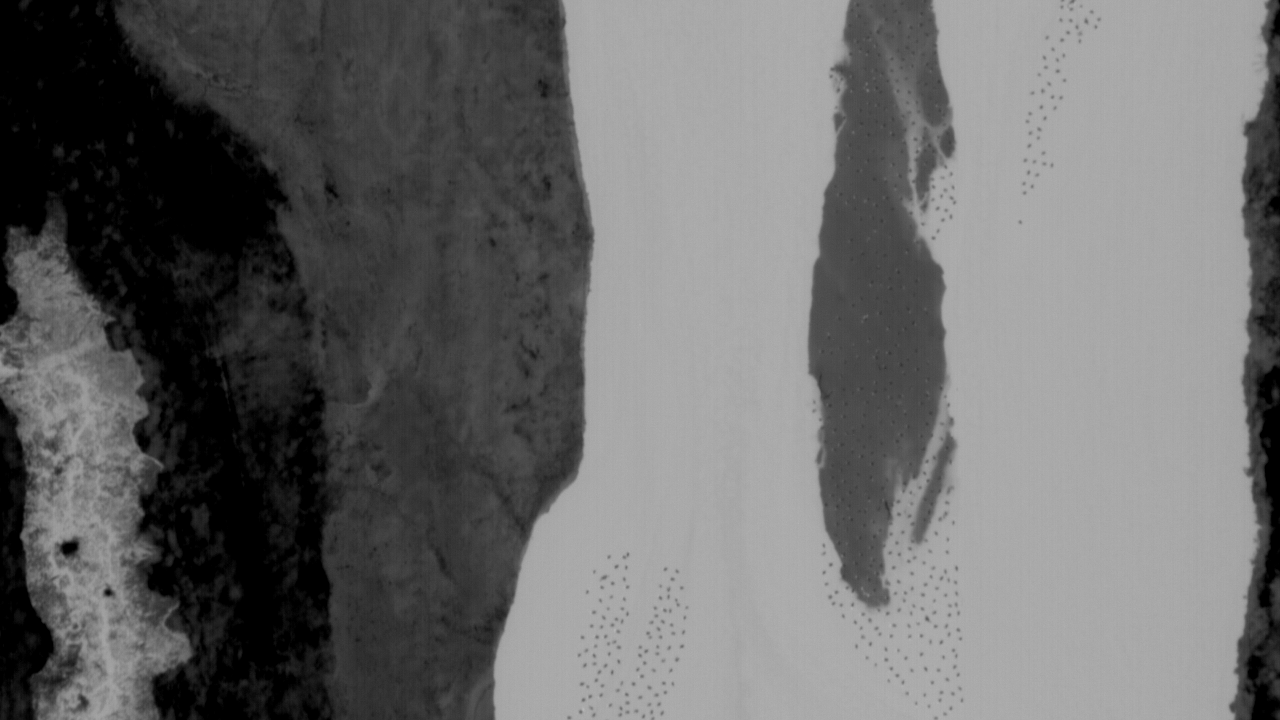

In [239]:
#Taken from way above...
img_fp = os.path.join(DATA_FP, 'images/FLIR2_20210321_225958_453_7161.TIF')
annot_fp = os.path.join(DATA_FP, 'annotations/FLIR2_20210321_225958_453_7161.xml')

image = Image.open(img_fp).convert('RGB')
bboxes = get_bboxes(annot_fp)
labels = np.ones((len(bboxes), ))
image

In [267]:
#Trying out tiling function
tiles, targets = tiling_w_o_overlap(image, bboxes, labels)

In [277]:
#Quickly checking final tile preparation
batch_of_tiles = []
for i, content in enumerate(zip(tiles, targets)):
    img, target = content
    target_dict = {}
    target_dict['boxes'] = torch.as_tensor(target['boxes'], dtype = torch.float32)
    target_dict['labels'] = torch.as_tensor(target['labels'], dtype = torch.int64)
    batch_of_tiles.append((img, target_dict))

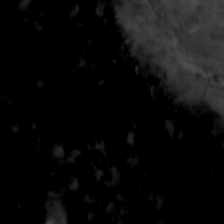

In [276]:
#Inspecting images
index = 0
img = np.moveaxis(tiles[index].numpy(), 0, -1) * 255
bb = targets[index]['boxes']

pil_img = Image.fromarray(img.astype(np.uint8))
draw = ImageDraw.Draw(pil_img)
for b in bb:
    draw.rectangle(b, outline = 'red', width = 1)
pil_img

## Testing ground truth density generation
Visual confirmation and time tests.

In [5]:
#Pulling inthe image and annotations
single_annot_fp = '/Users/emiliolr/Desktop/Conservation Research/final_dataset/annotations/20180321_223204_097_2806.xml'
single_img_fp = '/Users/emiliolr/Desktop/Conservation Research/final_dataset/images/20180321_223204_097_2806.tif'

bboxes = get_bboxes(single_annot_fp)
img = np.array(Image.open(single_img_fp))
img = np.moveaxis(img, -1, 0) #making the shape the same as a torch tensor

In [7]:
#Density w/adaptive filter
start = time.time()
adaptive_density = density_from_bboxes(bboxes, img, filter_type = 'adaptive')
end = time.time()
print(f'It took {end - start} seconds to produce the adaptive density')

It took 97.99705505371094 seconds to produce the adaptive density


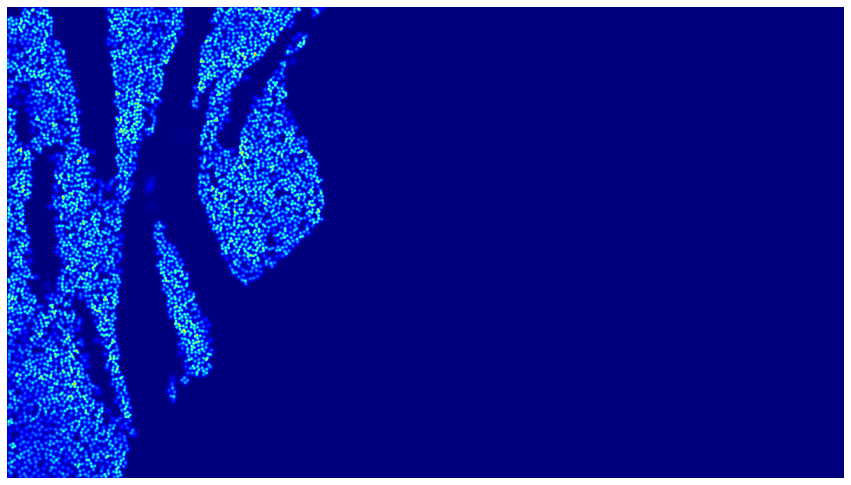

In [8]:
#Checking out the density
plt.figure(figsize = (15, 10))
plt.axis('off')
plt.imshow(adaptive_density, cmap = CM.jet);

In [10]:
#Does the density sum to the image count like it's supposed to?
print(f'Count according to adaptive density is {round(np.sum(adaptive_density))} and actual is {len(bboxes)}')

Count according to adaptive density is 3781 and actual is 3795


In [6]:
#Density w/fixed filter
start = time.time()
fixed_density = density_from_bboxes(bboxes, img, filter_type = 'fixed', sigma = 3)
end = time.time()
print(f'It took {end - start} seconds to produce the fixed density')

It took 0.12068295478820801 seconds to produce the fixed density


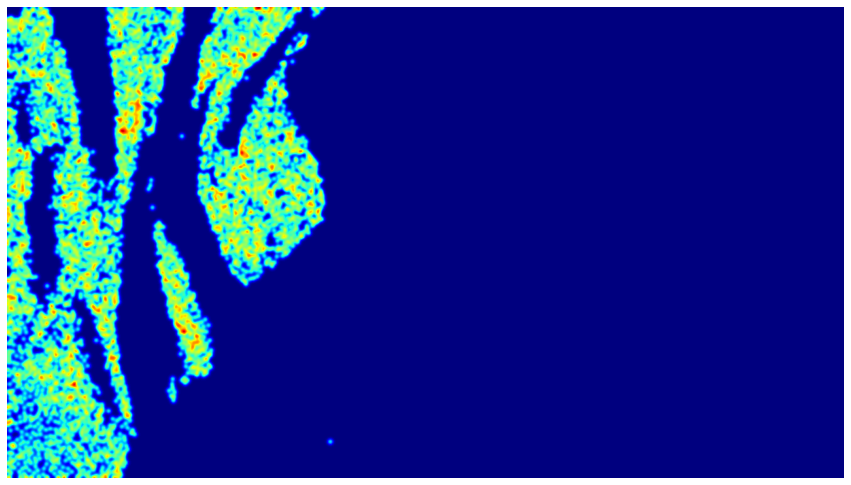

In [7]:
#Checking out the density
plt.figure(figsize = (15, 10))
plt.axis('off')
plt.imshow(fixed_density, cmap = CM.jet);

In [8]:
#Does the density sum to the image count like it's supposed to?
print(f'Count according to fixed density is {round(np.sum(fixed_density))} and actual is {len(bboxes)}')

Count according to fixed density is 3795 and actual is 3795


## Testing the `BirdDataset` object (density)

In [3]:
#Putting the dataset in a DataLoader
bird_dataset = BirdDataset(root_dir = DATA_FP, 
                           transforms = get_transforms(train = False), 
                           tiling_method = 'w_o_overlap', 
                           annotation_mode = 'points', 
                           tile_size = (200, 200), 
                           sigma = 3)
dataloader = DataLoader(bird_dataset, 
                        batch_size = 1, 
                        shuffle = False, 
                        collate_fn = collate_tiles_density)

#Pulling a batch out of the iterator
images, densities, counts = next(iter(dataloader))
print(f'Batch size of {len(images)} with each image tensor of shape {images[0].shape}')
print(f'We have a {type(densities)} of {type(densities[0])} for our densities')

Batch size of 28 with each image tensor of shape torch.Size([3, 200, 200])
We have a <class 'torch.Tensor'> of <class 'torch.Tensor'> for our densities


In [3]:
#A transformation to reverse normalization - for visualization!
invTrans = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0.],
                                                    std = [ 1 / 0.229, 1 / 0.224, 1 / 0.225]),
                               transforms.Normalize(mean = [ -0.485, -0.456, -0.406],
                                                    std = [ 1., 1., 1.]),
                               ])

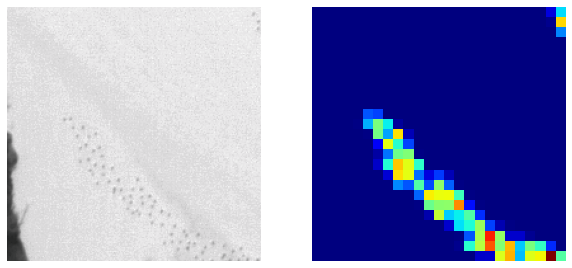

In [12]:
#Inspecting densities and images
index = 3
img = invTrans(images[index])
img = (np.moveaxis(img.numpy(), 0, -1) * 255).astype(np.uint8)
den = densities[index]

f, axarr = plt.subplots(1, 2, figsize = (10, 10))
axarr[0].imshow(img)
axarr[1].imshow(den, cmap = CM.jet)
for a in axarr:
    a.axis('off')

In [14]:
#Checking counts and how resizing affects counts
print(f'In image {index} there are {np.sum(den.numpy())} birds (there are actually {counts[index]} birds)')

In image 3 there are 73.85151672363281 birds (there are actually 74 birds)


In [7]:
#Getting rid of the negative values... they seem to be an artifact of the resizing
test_den = torch.clone(den)
test_den[test_den < 0] = 0
print(f'After getting rid of negative density values, the count is {np.sum(test_den.numpy())}')

After getting rid of negative density values, the count is 34.128273010253906


## Working with the rubber sheeted mosaic

In [28]:
#Reading in the file... its dtype is uint16
im = tif.imread('/Users/emiliolr/Desktop/crane_thermal_mosaic_test.tif')

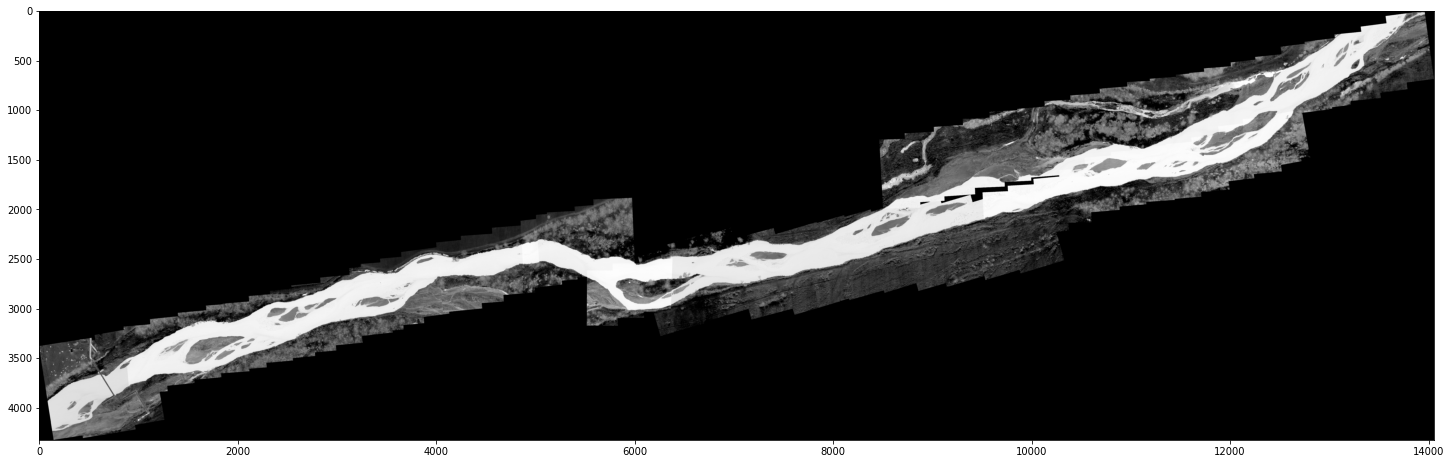

In [29]:
#Converting to 8-bit unsigned int and taking a look... this should work for our purposes!
im8 = im.astype(np.uint8)
plt.figure(figsize = (25, 45))
plt.imshow(im8)

In [30]:
#Saving as a an 8bit tif file
tif.imsave('/Users/emiliolr/Desktop/crane_thermal_mosaic_test_8bit.tif', im8)

## Checking elements of the final pipeline

In [10]:
#Making a dataset
dataset = BirdDatasetPREDICTION(os.path.join(CODE_FP, 'mosaic_tiles'))

In [11]:
#Making sure that pre-processing is working... can we reverse the process?
index = 189
img = invTrans(dataset[index])
img = (np.moveaxis(img.numpy(), 0, -1) * 255).astype(np.uint8)

plt.imshow(img)

NameError: name 'invTrans' is not defined

In [12]:
#Fitting a DataLoader around the dataset
tile_dataloader = DataLoader(dataset, batch_size = 32, shuffle = False)

for i, batch in enumerate(tile_dataloader):
    print(i)

0
1
2
3
4
5
6
7
8


In [27]:
from density_estimation.ASPDNet_model import ASPDNetLightning
from density_estimation.ASPDNet.model import ASPDNet
from object_detection.faster_rcnn_model import *

In [82]:
model_name = 'faster_rcnn'
model_save_fp = '/Users/emiliolr/Desktop/counting-cranes/best_models/faster_rcnn_BEST_MODEL.pth'
device = 'cpu'

In [83]:
if model_name == 'faster_rcnn':
    if model_save_fp.endswith('.pth'):
        model = get_faster_rcnn(backbone = 'ResNet50', num_classes = 2).to(device)
        model.load_state_dict(torch.load(model_save_fp))
        pl_model = FasterRCNNLightning(model)
    elif model_save_fp.endswith('.ckpt'):
        model = get_faster_rcnn(backbone = 'ResNet50', num_classes = 2).to(device)
        pl_model = FasterRCNNLightning.load_from_checkpoint(model_save_fp, model = model)
    else:
        raise NameError('File is not of type .pth or .ckpt')
elif model_name == 'ASPDNet':
    if model_save_fp.endswith('.pth'):
        model = ASPDNet(allow_neg_densities = False).to(device)
        model.load_state_dict(torch.load(model_save_fp))
        pl_model = ASPDNetLightning(model)
    elif model_save_fp.endswith('.ckpt'):
        model = ASPDNet(allow_neg_densities = False).to(device)
        pl_model = ASPDNetLightning.load_from_checkpoint(model_save_fp, model = model)
    else:
        raise NameError('File is not of type .pth or .ckpt')
else:
    raise NameError(f'Model "{model_name}" is not a supported model type')

In [84]:
fake_batch = torch.randn(2, 3, 200, 200)
pl_model.model.eval()
preds = pl_model(fake_batch)
pred_counts = pl_model.predict_counts(fake_batch)

In [89]:
preds

[{'boxes': tensor([[198.3214,  47.0072, 200.0000,  49.8613],
          [197.3507,  46.0004, 200.0000,  51.0861],
          [119.9383, 199.8958, 123.0136, 199.9998],
          [134.7853, 199.9209, 137.9895, 199.9997],
          [197.7094,  46.1221, 200.0000,  48.7282],
          [197.3216, 180.4601, 200.0000, 184.1150],
          [131.9093, 199.8102, 135.1322, 200.0000],
          [133.8342, 199.8132, 136.9496, 200.0000],
          [198.3005,  17.0910, 200.0000,  19.7072]], grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'scores': tensor([0.3101, 0.2763, 0.2674, 0.2511, 0.2195, 0.1343, 0.0725, 0.0620, 0.0575],
         grad_fn=<IndexBackward>)},
 {'boxes': tensor([[ 70.7220, 199.9515,  73.9570, 199.9998],
          [ 80.6329, 199.9018,  83.8486, 200.0000],
          [ 16.5631, 199.9021,  20.0033, 199.9998],
          [ 15.4336, 199.9596,  18.7630, 199.9999],
          [198.2068, 140.2077, 199.9871, 143.3178],
          [ 42.7182, 199.9480,  45.8706, 200.0000

In [78]:
print(float(preds.sum()))
print(sum(pred_counts))

2509.669189453125
2509.6690979003906


In [85]:
print([len(p['boxes'].tolist()) for p in preds])
print(pred_counts)

[9, 10]
[9, 10]
